In [1]:
try:
    import numpy as np
except ImportError:
    %pip install numpy
    import numpy as np
try:
    import matplotlib.pyplot as plt
except ImportError:
    %pip install matplotlib
    import matplotlib.pyplot as plt

data_dir = "new/sliding_window/exponential"

prescribed = np.loadtxt(f"{data_dir}/Prescribed_Replicas.csv", delimiter = ",", dtype = str, skiprows = 1)
instatiated = np.loadtxt(f"{data_dir}/Total_Pods_Instantiated.csv", delimiter = ",", dtype = str, skiprows = 1)

queue = np.loadtxt(f"{data_dir}/Queue_Metrics.csv", delimiter = ",", dtype = str, skiprows = 1)

In [2]:
prescribed_x = prescribed[:, 0].astype(int) / 1000
prescribed_y = prescribed[:, 1].astype(float)

instatiated_x = instatiated[:, 0].astype(int) / 1000
instatiated_y = instatiated[:, 1].astype(float)

In [3]:
def make_incremental(array):
    start = array[0]
    for i in range(len(array)):
        array[i] = array[i] - start
    return array
    
def make_cumulative(array):
    cumulative = []
    cumulative.append(array[0])
    for i in range(1, len(array)):
        cumulative.append(array[i] + cumulative[-1])
    return cumulative

In [4]:
start_time_p = prescribed_x[0]
start_time_i = instatiated_x[0]
for i in range(len(prescribed_x)):
    prescribed_x[i] = prescribed_x[i] - start_time_p

for i in range(len(instatiated_x)):
    instatiated_x[i] = instatiated_x[i] - start_time_i

Prescribed Sirio Cost: 5420.0
Effective Sirio Cost: 6940.0
Absolute Inefficiency: 1520.0
Relative Inefficiency: 28.04%


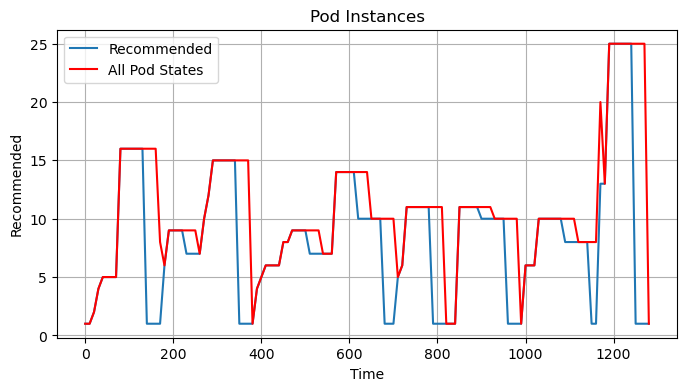

In [5]:
interval = 5
plt.figure(figsize = (8, 4))
plt.plot(prescribed_x, prescribed_y, label = "Recommended")
plt.plot(instatiated_x, instatiated_y, color = "red", label = "All Pod States")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Recommended")
plt.title("Pod Instances")

plt.savefig(f"{data_dir}/pods.png")

cost_pres = sum(prescribed_y) * interval
cost_insta = sum(instatiated_y) * interval

inefficiency = cost_insta - cost_pres
print(f"Prescribed Sirio Cost: {cost_pres}")
print(f"Effective Sirio Cost: {cost_insta}")
print(f"Absolute Inefficiency: {inefficiency}")
print("Relative Inefficiency: %.2f%%" % (inefficiency/cost_pres * 100))

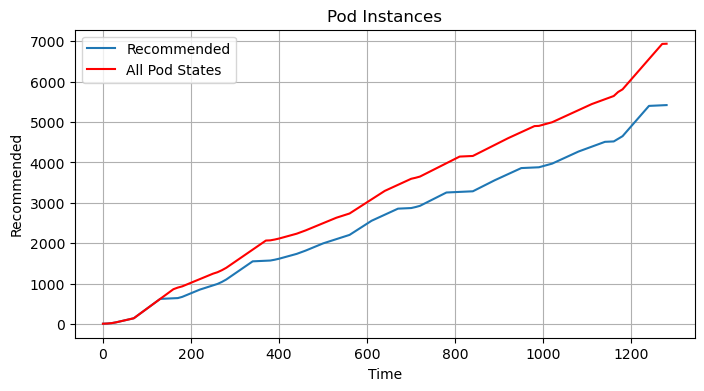

In [6]:
cumulative_prescribed_cost = [0] * len(prescribed_y)
cumulative_effective_cost = [0] * len(instatiated_y)

cumulative_prescribed_cost[0] = prescribed_y[0] * interval
cumulative_effective_cost[0] = instatiated_y[0] * interval
# Iterate up to the minimum length of the two arrays to avoid index errors
loop_range = min(len(prescribed_y), len(instatiated_y))
for i in range(loop_range - 1):
    cumulative_prescribed_cost[i + 1] = cumulative_prescribed_cost[i] + prescribed_y[i + 1] * interval
    cumulative_effective_cost[i + 1] = cumulative_effective_cost[i] + instatiated_y[i + 1] * interval

plt.figure(figsize = (8, 4))
plt.plot(prescribed_x, cumulative_prescribed_cost, label = "Recommended")
plt.plot(instatiated_x, cumulative_effective_cost, color = "red", label = "All Pod States")
plt.grid()
plt.legend()
plt.ylabel("Recommended")
plt.xlabel("Time")
plt.title("Pod Instances")


plt.savefig(f"{data_dir}/pods_cumulative.png")


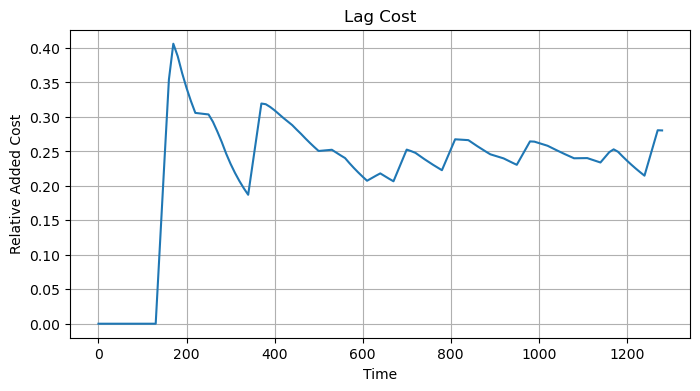

In [7]:
inefficiency = np.subtract(cumulative_effective_cost, cumulative_prescribed_cost)
relative_inefficiency = inefficiency / cumulative_prescribed_cost

plt.figure(figsize = (8, 4))
plt.plot(prescribed_x, relative_inefficiency)
plt.grid()
plt.xlabel("Time")
plt.ylabel("Relative Added Cost")
plt.title("Lag Cost")

plt.savefig(f"{data_dir}/lag_cost_cumulative.png")


In [8]:
queue_x = make_incremental(queue[:, 0].astype(int) / 1000)
queue_msg = queue[:, 1].astype(float)
queue_rej = queue[:, 2].astype(float)

cumulative_msg = np.cumsum(queue_msg)
cumulative_rej = np.cumsum(queue_rej)

np.seterr(invalid = "ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

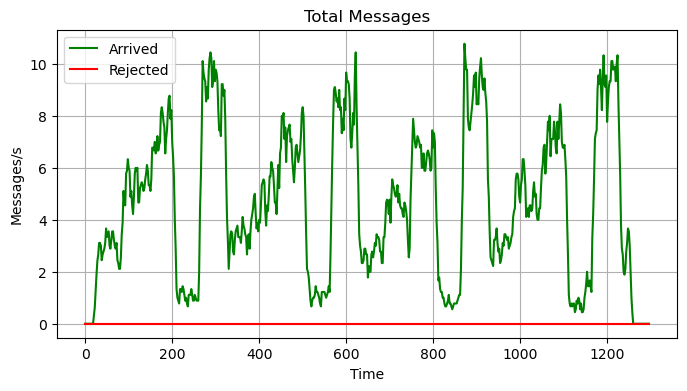

In [9]:
plt.figure(figsize = (8, 4))

plt.plot(queue_x, queue_msg, color = "green", label = "Arrived")
plt.plot(queue_x, queue_rej, color = "red", label = "Rejected")
plt.title("Total Messages")
plt.legend()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Messages/s")

plt.savefig(f"{data_dir}/messages.png")


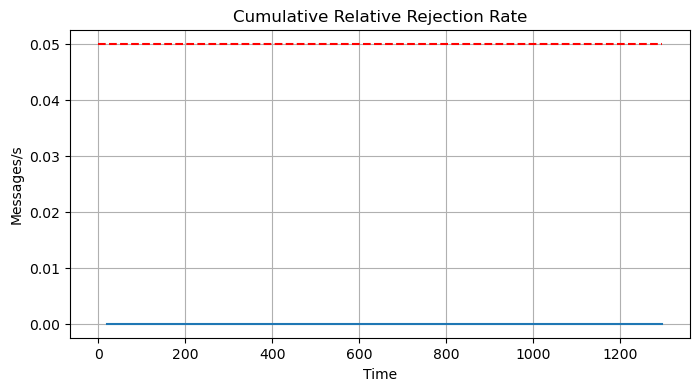

In [10]:
plt.figure(figsize = (8, 4))

plt.hlines(0.05, min(queue_x), max(queue_x), color = "red", linestyle = "dashed")
plt.plot(queue_x, np.divide(cumulative_rej, cumulative_msg))
plt.grid(visible = True)
plt.title("Cumulative Relative Rejection Rate")
plt.xlabel("Time")
plt.ylabel("Messages/s")

plt.savefig(f"{data_dir}/rejection_cumulative.png")


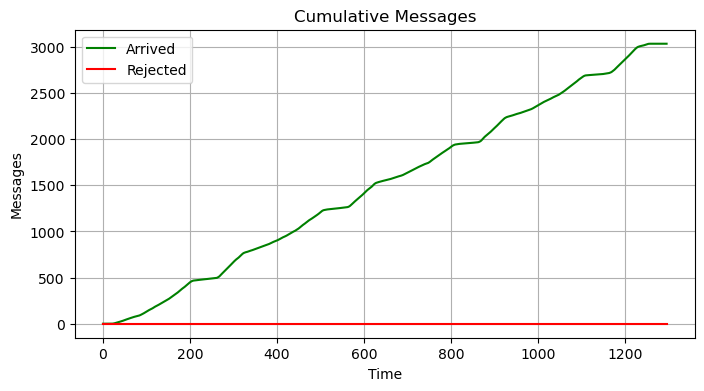

In [11]:
plt.figure(figsize = (8, 4))
plt.plot(queue_x, cumulative_msg, color = "green", label = "Arrived")
plt.plot(queue_x, cumulative_rej, color = "red", label = "Rejected")
plt.grid()

plt.legend()
plt.title("Cumulative Messages")
plt.ylabel("Messages")
plt.xlabel("Time")

plt.savefig(f"{data_dir}/messages_cumulative.png")

In [12]:
total_msg = sum(queue_msg) * 5
total_rej = sum(queue_rej) * 5

actual_rej = total_rej / total_msg
print("Total Rejection Rate: %.2f%%" % (actual_rej * 100))

Total Rejection Rate: 0.00%
